In [12]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

In [13]:
## 데이터로드
dataset = pd.read_csv("train.csv",index_col=0)

In [14]:
dataset.index = pd.to_datetime(dataset.index)

In [15]:
dataset

,4단지배수지 공업 유출유량 적산차
datetime,
2017-01-01 01:00:00,525.0
2017-01-01 02:00:00,542.0
2017-01-01 03:00:00,392.0
2017-01-01 04:00:00,379.0
2017-01-01 05:00:00,353.0
...,...
2020-12-31 19:00:00,626.0
2020-12-31 20:00:00,294.0
2020-12-31 21:00:00,234.0


In [5]:
## 시계열 학습 데이터셋 구축 함수

from pandas import concat,DataFrame
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
## 값뽑아내기
values = dataset.values
values = values.astype("float32")


In [7]:
scaler = MinMaxScaler()
scaler.fit(values)
scaled = scaler.transform(values)

In [8]:
reframed = series_to_supervised(scaled,24*7,1)

In [9]:
reframed

,var1(t-168),var1(t-167),var1(t-166),var1(t-165),var1(t-164),var1(t-163),var1(t-162),var1(t-161),var1(t-160),var1(t-159),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
168,0.350233,0.361574,0.261508,0.252835,0.235490,0.178786,0.319546,0.228819,0.281521,0.384923,...,0.458306,0.283522,0.339560,0.288192,0.125417,0.349566,0.474316,0.342228,0.218145,0.319546
169,0.361574,0.261508,0.252835,0.235490,0.178786,0.319546,0.228819,0.281521,0.384923,0.222148,...,0.283522,0.339560,0.288192,0.125417,0.349566,0.474316,0.342228,0.218145,0.319546,0.368246
170,0.261508,0.252835,0.235490,0.178786,0.319546,0.228819,0.281521,0.384923,0.222148,0.341561,...,0.339560,0.288192,0.125417,0.349566,0.474316,0.342228,0.218145,0.319546,0.368246,0.224149
171,0.252835,0.235490,0.178786,0.319546,0.228819,0.281521,0.384923,0.222148,0.341561,0.338893,...,0.288192,0.125417,0.349566,0.474316,0.342228,0.218145,0.319546,0.368246,0.224149,0.388259
172,0.235490,0.178786,0.319546,0.228819,0.281521,0.384923,0.222148,0.341561,0.338893,0.436291,...,0.125417,0.349566,0.474316,0.342228,0.218145,0.319546,0.368246,0.224149,0.388259,0.322215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35058,0.325550,0.185457,0.278853,0.326885,0.228152,0.322882,0.214810,0.374917,0.181454,0.197465,...,0.304203,0.186791,0.437625,0.232155,0.180120,0.405604,0.317545,0.210807,0.238826,0.417612
35059,0.185457,0.278853,0.326885,0.228152,0.322882,0.214810,0.374917,0.181454,0.197465,0.370914,...,0.186791,0.437625,0.232155,0.180120,0.405604,0.317545,0.210807,0.238826,0.417612,0.196131
35060,0.278853,0.326885,0.228152,0.322882,0.214810,0.374917,0.181454,0.197465,0.370914,0.225484,...,0.437625,0.232155,0.180120,0.405604,0.317545,0.210807,0.238826,0.417612,0.196131,0.156104
35061,0.326885,0.228152,0.322882,0.214810,0.374917,0.181454,0.197465,0.370914,0.225484,0.229486,...,0.232155,0.180120,0.405604,0.317545,0.210807,0.238826,0.417612,0.196131,0.156104,0.469646


In [16]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)



In [17]:
dataX, dataY = build_dataset(values, 24*7)

In [18]:
values
X_train, X_temp, y_train, y_temp = train_test_split(dataX,dataY, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp, test_size=0.5, shuffle=False)

In [19]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape)

(27916, 168, 1) (27916, 1) (3489, 168, 1) (3489, 1)


In [20]:
trainX_tensor = torch.FloatTensor(X_train)
trainY_tensor = torch.FloatTensor(y_train)

valX_tensor = torch.FloatTensor(X_val)
valY_tensor = torch.FloatTensor(y_val)

testX_tensor = torch.FloatTensor(X_test)
testY_tensor = torch.FloatTensor(y_test)

In [21]:
trainX_tensor

tensor([[[525.],
         [542.],
         [392.],
         ...,
         [711.],
         [513.],
         [327.]],

        [[542.],
         [392.],
         [379.],
         ...,
         [513.],
         [327.],
         [479.]],

        [[392.],
         [379.],
         [353.],
         ...,
         [327.],
         [479.],
         [552.]],

        ...,

        [[246.],
         [216.],
         [452.],
         ...,
         [416.],
         [216.],
         [262.]],

        [[216.],
         [452.],
         [220.],
         ...,
         [216.],
         [262.],
         [350.]],

        [[452.],
         [220.],
         [500.],
         ...,
         [262.],
         [350.],
         [272.]]])

In [22]:
train_set = TensorDataset(trainX_tensor, trainY_tensor)
val_set = TensorDataset(valX_tensor, valY_tensor)
test_set = TensorDataset(testX_tensor, testY_tensor)

In [23]:
train_set[1]

(tensor([[542.],
         [392.],
         [379.],
         [353.],
         [268.],
         [479.],
         [343.],
         [422.],
         [577.],
         [333.],
         [512.],
         [508.],
         [654.],
         [351.],
         [447.],
         [495.],
         [446.],
         [343.],
         [513.],
         [517.],
         [407.],
         [294.],
         [506.],
         [637.],
         [397.],
         [276.],
         [388.],
         [404.],
         [429.],
         [582.],
         [340.],
         [382.],
         [310.],
         [424.],
         [497.],
         [590.],
         [539.],
         [514.],
         [551.],
         [555.],
         [601.],
         [458.],
         [590.],
         [387.],
         [564.],
         [513.],
         [455.],
         [612.],
         [331.],
         [320.],
         [584.],
         [421.],
         [460.],
         [543.],
         [508.],
         [349.],
         [534.],
         [481.],
         [576.

In [24]:
train_set.__getitem__(1)

(tensor([[542.],
         [392.],
         [379.],
         [353.],
         [268.],
         [479.],
         [343.],
         [422.],
         [577.],
         [333.],
         [512.],
         [508.],
         [654.],
         [351.],
         [447.],
         [495.],
         [446.],
         [343.],
         [513.],
         [517.],
         [407.],
         [294.],
         [506.],
         [637.],
         [397.],
         [276.],
         [388.],
         [404.],
         [429.],
         [582.],
         [340.],
         [382.],
         [310.],
         [424.],
         [497.],
         [590.],
         [539.],
         [514.],
         [551.],
         [555.],
         [601.],
         [458.],
         [590.],
         [387.],
         [564.],
         [513.],
         [455.],
         [612.],
         [331.],
         [320.],
         [584.],
         [421.],
         [460.],
         [543.],
         [508.],
         [349.],
         [534.],
         [481.],
         [576.

In [25]:
train_dataloader = DataLoader(train_set,
                        batch_size=32,
                        shuffle=False,  
                        drop_last=True)

val_dataloader = DataLoader(val_set,
                        batch_size=32,
                        shuffle=False,  
                        drop_last=True)

In [26]:
data_dim = 1
hidden_dim = 168
output_dim = 1
learning_rate = 0.01
nb_epochs = 5
seq_length = 24*7

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [27]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [28]:
def train_model(model, train_df,val_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = []
    val_hist = []
    model.train()## 학습모드
    
    for epoch in range(nb_epochs):
        train_losses = []
        val_losses = []
        
        total = tqdm(train_df)
        for samples in total:

            x_train, y_train = samples
            
            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                   
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item()) 
            
            
        train_loss = np.mean(train_losses)
        train_hist.append(train_loss)     
        
        ## 검증
        model.eval()
        for data in val_df:
            val_x, val_y = data
            pred = model(val_x)
            
            val_loss = criterion(pred, val_y)

            val_losses.append(val_loss.item())
            
        val_cost = np.mean(val_losses)    
        val_hist.append(val_cost)   
        
        print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(train_loss), 'val loss :', '{:.4f}'.format(val_cost))
            
        ## val loss가 줄어들었으면 모델 저장
        
        if epoch > 3:
            if (val_hist[-1] < val_hist[-2]):
                counter = 0
                torch.save(model.state_dict(), "checkpoint.pt")
                
            # loss가 커졌다면 early stop
            if (val_hist[-1] > val_hist[-2]):
                    counter = counter + 1
                    
            if counter == patience:
                model = model.load_state_dict(torch.load("checkpoint.pt"))
                return model.eval(), train_hist, val_hist
                

            
    return model.eval(), train_hist, val_hist

In [29]:
lstm = Net(data_dim, hidden_dim, seq_length, output_dim, layers=2)

In [30]:
model, train_hist, val_hist = train_model(lstm, train_dataloader, val_dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 1, patience = 10)

 30%|███       | 265/872 [02:06<05:06,  1.98it/s]

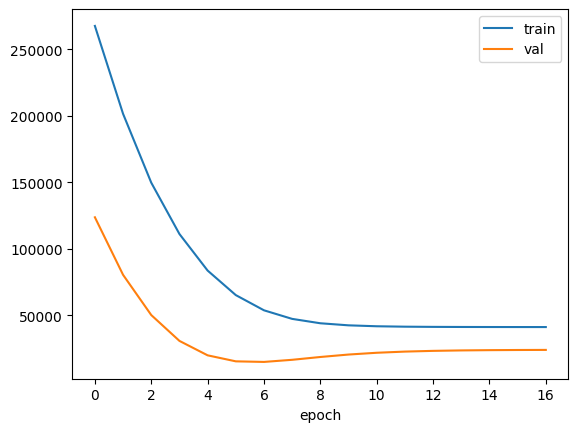

In [136]:
plt.xlabel("epoch")
plt.plot(train_hist,label = "train")
plt.plot(val_hist,label = "val")
plt.legend()
plt.show()

In [116]:
## 테스트데이터 불러오기

test = pd.read_csv("./data_4dist/data_ts_4dist.csv",encoding="utf-8",index_col=0)

In [137]:
model.eval()

for x,y in test_set:
    model(x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x168 and 10x1)

In [117]:
test

,4단지배수지 공업 유출유량 적산차
datetime,
2021-01-01 00:00:00,366.0
2021-01-01 01:00:00,486.0
2021-01-01 02:00:00,364.0
2021-01-01 03:00:00,356.0
2021-01-01 04:00:00,500.0
...,...
2021-12-17 19:00:00,690.0
2021-12-17 20:00:00,510.0
2021-12-17 21:00:00,432.0


In [118]:
test.index = pd.to_datetime(test.index)

In [119]:
print(test)
print(test.index.dtype)

                     4단지배수지 공업 유출유량 적산차
datetime                               
2021-01-01 00:00:00               366.0
2021-01-01 01:00:00               486.0
2021-01-01 02:00:00               364.0
2021-01-01 03:00:00               356.0
2021-01-01 04:00:00               500.0
...                                 ...
2021-12-17 19:00:00               690.0
2021-12-17 20:00:00               510.0
2021-12-17 21:00:00               432.0
2021-12-17 22:00:00               564.0
2021-12-17 23:00:00               700.0

[8424 rows x 1 columns]
datetime64[ns]


In [244]:
test["4단지배수지 공업 유출유량 적산차"] = scaler.transform(test)

c:\Users\R\anaconda3\envs\yolo\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [127]:
test

,4단지배수지 공업 유출유량 적산차
datetime,
2021-01-01 00:00:00,366.0
2021-01-01 01:00:00,486.0
2021-01-01 02:00:00,364.0
2021-01-01 03:00:00,356.0
2021-01-01 04:00:00,500.0
...,...
2021-12-17 19:00:00,690.0
2021-12-17 20:00:00,510.0
2021-12-17 21:00:00,432.0


In [121]:
reframed_test = series_to_supervised(test.values.astype("float32"),24*7,1)

In [122]:
reframed_test

,var1(t-168),var1(t-167),var1(t-166),var1(t-165),var1(t-164),var1(t-163),var1(t-162),var1(t-161),var1(t-160),var1(t-159),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
168,366.0,486.0,364.0,356.0,500.0,328.0,216.0,546.0,486.0,220.0,...,504.0,348.0,420.0,692.0,264.0,372.0,548.0,450.0,330.0,576.0
169,486.0,364.0,356.0,500.0,328.0,216.0,546.0,486.0,220.0,408.0,...,348.0,420.0,692.0,264.0,372.0,548.0,450.0,330.0,576.0,604.0
170,364.0,356.0,500.0,328.0,216.0,546.0,486.0,220.0,408.0,558.0,...,420.0,692.0,264.0,372.0,548.0,450.0,330.0,576.0,604.0,360.0
171,356.0,500.0,328.0,216.0,546.0,486.0,220.0,408.0,558.0,318.0,...,692.0,264.0,372.0,548.0,450.0,330.0,576.0,604.0,360.0,352.0
172,500.0,328.0,216.0,546.0,486.0,220.0,408.0,558.0,318.0,290.0,...,264.0,372.0,548.0,450.0,330.0,576.0,604.0,360.0,352.0,712.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8419,796.0,724.0,486.0,708.0,646.0,732.0,748.0,684.0,532.0,796.0,...,544.0,696.0,626.0,570.0,510.0,818.0,690.0,518.0,480.0,690.0
8420,724.0,486.0,708.0,646.0,732.0,748.0,684.0,532.0,796.0,514.0,...,696.0,626.0,570.0,510.0,818.0,690.0,518.0,480.0,690.0,510.0
8421,486.0,708.0,646.0,732.0,748.0,684.0,532.0,796.0,514.0,678.0,...,626.0,570.0,510.0,818.0,690.0,518.0,480.0,690.0,510.0,432.0
8422,708.0,646.0,732.0,748.0,684.0,532.0,796.0,514.0,678.0,600.0,...,570.0,510.0,818.0,690.0,518.0,480.0,690.0,510.0,432.0,564.0


In [134]:
test_x, test_y = build_dataset(test.values, 24*7)

In [138]:
test_x.shape

(8256, 168, 1)

In [133]:
type(test_2)

tuple

In [140]:
t = test.tail(8256).values
t

array([[576.],
       [604.],
       [360.],
       ...,
       [432.],
       [564.],
       [700.]])

In [126]:
new_test

,var1(t-168),var1(t-167),var1(t-166),var1(t-165),var1(t-164),var1(t-163),var1(t-162),var1(t-161),var1(t-160),var1(t-159),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
34895,0.377585,0.201468,0.160107,0.361574,0.265510,0.178786,0.221481,0.330887,0.196131,0.300200,...,0.458973,0.449633,0.212141,0.322882,0.325550,0.185457,0.278853,0.326885,0.228152,0.322882
34896,0.201468,0.160107,0.361574,0.265510,0.178786,0.221481,0.330887,0.196131,0.300200,0.253502,...,0.449633,0.212141,0.322882,0.325550,0.185457,0.278853,0.326885,0.228152,0.322882,0.214810
34897,0.160107,0.361574,0.265510,0.178786,0.221481,0.330887,0.196131,0.300200,0.253502,0.306871,...,0.212141,0.322882,0.325550,0.185457,0.278853,0.326885,0.228152,0.322882,0.214810,0.374917
34898,0.361574,0.265510,0.178786,0.221481,0.330887,0.196131,0.300200,0.253502,0.306871,0.450967,...,0.322882,0.325550,0.185457,0.278853,0.326885,0.228152,0.322882,0.214810,0.374917,0.181454
34899,0.265510,0.178786,0.221481,0.330887,0.196131,0.300200,0.253502,0.306871,0.450967,0.194797,...,0.325550,0.185457,0.278853,0.326885,0.228152,0.322882,0.214810,0.374917,0.181454,0.197465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8419,796.000000,724.000000,486.000000,708.000000,646.000000,732.000000,748.000000,684.000000,532.000000,796.000000,...,544.000000,696.000000,626.000000,570.000000,510.000000,818.000000,690.000000,518.000000,480.000000,690.000000
8420,724.000000,486.000000,708.000000,646.000000,732.000000,748.000000,684.000000,532.000000,796.000000,514.000000,...,696.000000,626.000000,570.000000,510.000000,818.000000,690.000000,518.000000,480.000000,690.000000,510.000000
8421,486.000000,708.000000,646.000000,732.000000,748.000000,684.000000,532.000000,796.000000,514.000000,678.000000,...,626.000000,570.000000,510.000000,818.000000,690.000000,518.000000,480.000000,690.000000,510.000000,432.000000
8422,708.000000,646.000000,732.000000,748.000000,684.000000,532.000000,796.000000,514.000000,678.000000,600.000000,...,570.000000,510.000000,818.000000,690.000000,518.000000,480.000000,690.000000,510.000000,432.000000,564.000000


In [155]:
test = new_test.values
X_test = test[:,:-1]
y_test = test[:,-1:]

In [156]:
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

In [157]:
y_test

array([[0.32555038, 0.21347566, 0.13875918, ..., 0.22014678, 0.28552368,
        0.19479653],
       [0.21347566, 0.13875918, 0.26684457, ..., 0.28552368, 0.19479653,
        0.20547032],
       [0.13875918, 0.26684457, 0.24016011, ..., 0.19479653, 0.20547032,
        0.43495664],
       ...,
       [0.3335557 , 0.26017347, 0.40827218, ..., 0.46030688, 0.34022683,
        0.28819212],
       [0.26017347, 0.40827218, 0.34022683, ..., 0.34022683, 0.28819212,
        0.37625083],
       [0.40827218, 0.34022683, 0.28285524, ..., 0.28819212, 0.37625083,
        0.46697798]], dtype=float32)

In [141]:
test_dataset = TensorDataset(torch.FloatTensor(test_x),torch.FloatTensor(test_y))
tds = DataLoader(test_dataset,shuffle=False)
model.eval()
yhat = []

for (x,y) in tds:
    pred = model(x)
    
    yhat.append(pred.detach().numpy())

ans = np.array(yhat)

    

In [142]:
ans

array([[[414.12573]],

       [[414.12573]],

       [[414.12573]],

       ...,

       [[414.12573]],

       [[414.12573]],

       [[414.12573]]], dtype=float32)

In [161]:
ans_inverse_transform = scaler.inverse_transform(ans.reshape(-1,336))

In [168]:
df_ans = pd.DataFrame(data=ans_inverse_transform, columns= list(map(str, [("h"+str(x)) for x in range(336)])))

In [171]:
df_ans.to_csv("ans.csv", index=False)

In [167]:
list(map(int, [i for i in range(1,11)]))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [176]:
plt.plot(ans_inverse_transform[:,0])
plt.plot(test["4단지배수지 공업 유출유량 적산차"])

Error in callback <function flush_figures at 0x000001536A426310> (for post_execute):


KeyboardInterrupt: 

In [177]:
ans_inverse_transform[:,0]

array([408.45074, 408.462  , 408.4602 , ..., 408.32904, 408.32587,
       408.3296 ], dtype=float32)

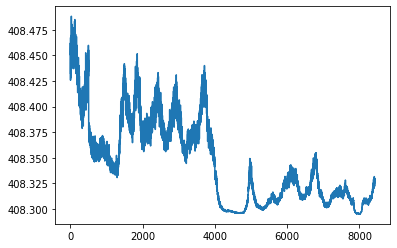

In [181]:
# plt.plot(test["4단지배수지 공업 유출유량 적산차"].values)
plt.plot(ans_inverse_transform[:,0])